In [1]:
import numpy as np
from sklearn.datasets import make_moons, make_circles
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from math import exp
from sklearn.cluster import KMeans
from scipy.linalg import fractional_matrix_power
from scipy.spatial import distance
import pandas as pd

RS = 1
sns.set_theme(style="white")

---

## Clusterização espectral global

In [2]:
def matriz_afinidade(X, sigma):
    n = X.shape[0]
    A = np.zeros((n, n))
    
    dist = distance.cdist(X, X, metric="euclidean")
    for i in range(n):
        for j in range(i+1, n):
            A[i, j] = A[j, i] = np.exp(- dist[i, j]**2 / (2*sigma**2))
    
    return A

In [3]:
def matriz_diagonal(M):
    """
    retorna uma matriz diagonal com cada elemento
    correspondendo à soma das linhas de M
    """
    return np.diag(M.sum(axis=1))

In [4]:
def espectral(X, k, sigma):
    A = matriz_afinidade(X, sigma)
    D = matriz_diagonal(A)
    
    L = D-A
    
    D = np.linalg.pinv(D)
    D = fractional_matrix_power(D, 1/2)
    
    L = D @ L @ D
    
    autovalores, autovetores = np.linalg.eigh(L)
    V = autovetores[:, :k]

    for i in range(len(V)):
        norma = np.linalg.norm(V[i])
        if norma > 1e-8:
            V[i] /= norma
        
        
    return KMeans(n_clusters=k, n_init="auto", random_state=RS).fit_predict(V)

---

## Clusterização espectral local

In [5]:
def matriz_afinidade2(X):
    n = X.shape[0]    
    dist = distance.cdist(X, X, metric="euclidean")
    
    sigmas = np.zeros(n)
    for i in range(n):
        sigmas[i] = sorted(dist[i])[7]
    
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = np.exp(-dist[i, j]**2 / (sigmas[i] * sigmas[j]))**2
            A[i, j] = A[j, i] = d
    
    return A

In [6]:
def espectral2(X, k):
    A = matriz_afinidade2(X)
    D = matriz_diagonal(A)
    
    L = D - A
    
    D = np.linalg.pinv(D)
    D = fractional_matrix_power(D, 1/2)
    
    L = D @ L @ D
    
    _, autovetores = np.linalg.eigh(L)
    V = autovetores[:, :k]
    
    for i in range(len(V)):
        norma = np.linalg.norm(V[i])
        if norma > 1e-8:
            V[i] /= norma
        
    return KMeans(n_clusters=k, n_init="auto", random_state=RS).fit_predict(V)

---

## Visualizando o funcionamento do algoritmo

In [7]:
def base_espectral(X, k, grupos):
    A = matriz_afinidade2(X)
    D = matriz_diagonal(A)
    
    L = D - A
    
    D = np.linalg.pinv(D)
    D = fractional_matrix_power(D, 1/2)
    
    L = D @ L @ D
    
    _, autovetores = np.linalg.eigh(L)
    V = autovetores[:, :k]
    
    for i in range(len(V)):
        V[i] /= np.linalg.norm(V[i])
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=grupos, legend=False, ax=axes[0])
    sns.scatterplot(x=V[:,0], y=V[:,1], hue=grupos, legend=False, ax=axes[1])
    axes[0].set(title="Pontos originais")
    axes[1].set(title="Transposição via 1° e 2° autovetores")
    fig.tight_layout()

In [8]:
circulos, grupos = make_circles(n_samples=500, noise=0.01, random_state=RS)

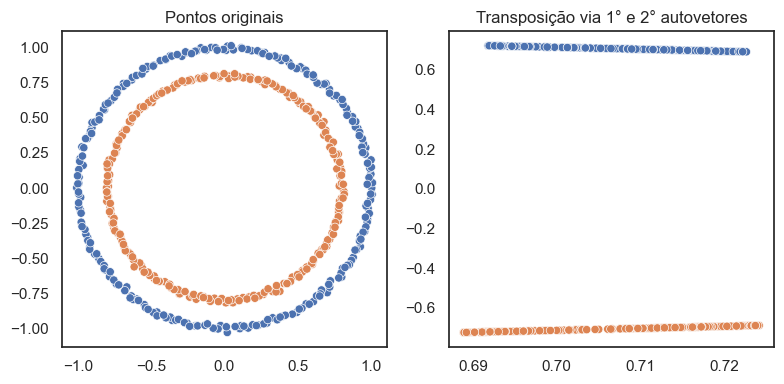

In [9]:
base_espectral(circulos, 2, grupos)

In [10]:
luas, grupos = make_moons(n_samples=300, noise=0.05, random_state=RS)

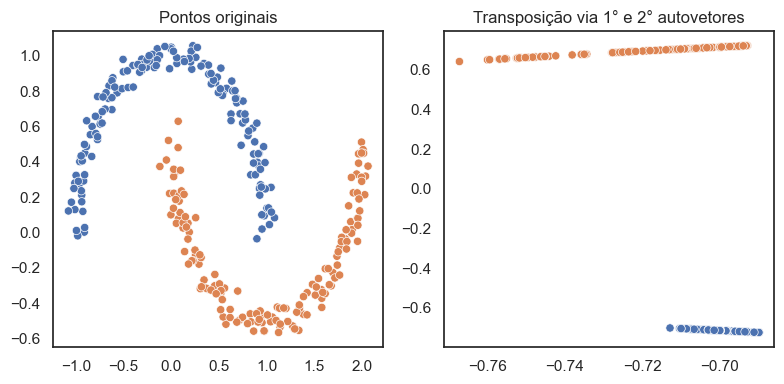

In [11]:
base_espectral(luas, 2, grupos)

---

## Testes

### Referência

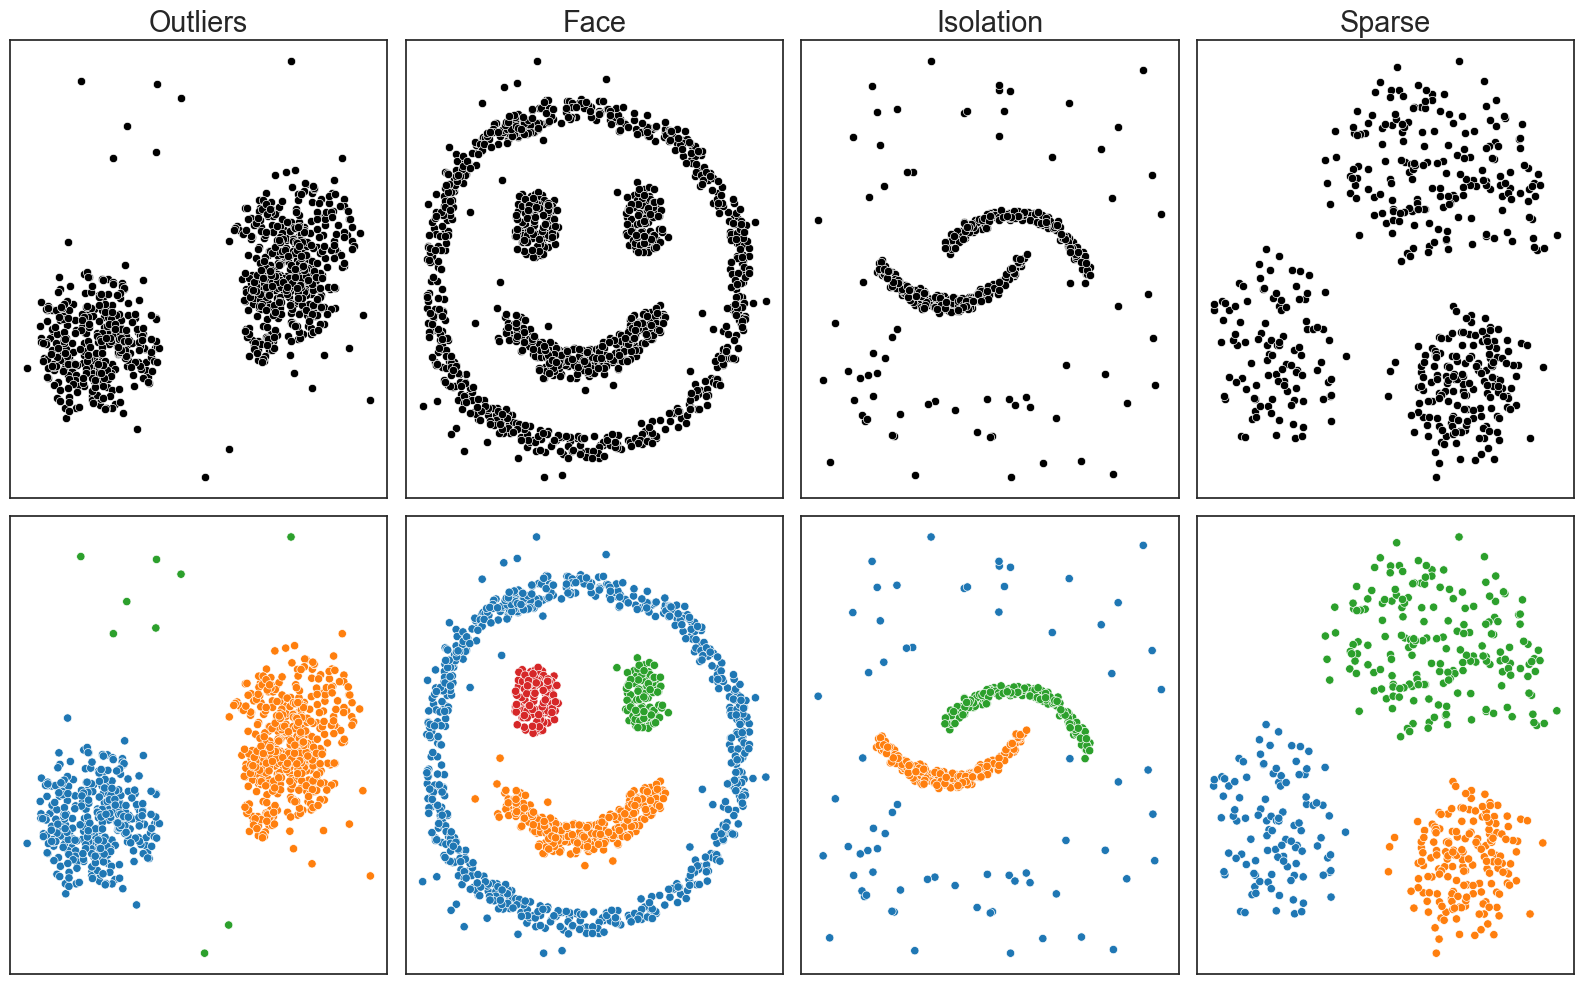

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
for i, arq in enumerate(["outliers", "face", "isolation", "sparse"]):
    X = pd.read_csv(f"testes/{arq}.csv")
    
    sns.scatterplot(X, x="x", y="y", c="black", ax=axes[0][i])
    axes[0][i].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
    axes[0][i].set_title(arq.title(), fontsize="xx-large")
    
    sns.scatterplot(X, x="x", y="y", hue="color", palette="tab10", legend=False, ax=axes[1][i])
    axes[1][i].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])

fig.tight_layout()

### Escala global

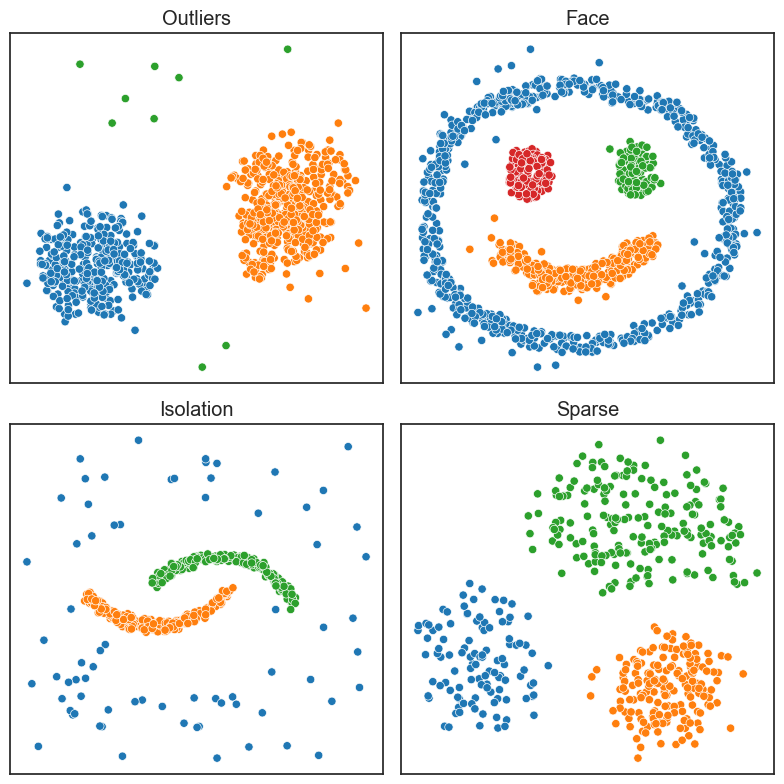

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

X = pd.read_csv("testes/outliers.csv")
sns.scatterplot(X, x="x", y="y", hue="color", palette="tab10", legend=False, ax=axes[0][0])
axes[0][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][0].set_title("Outliers", fontsize="large")

X = pd.read_csv("testes/face.csv")
sns.scatterplot(X, x="x", y="y", hue="color", palette="tab10", legend=False, ax=axes[0][1])
axes[0][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][1].set_title("Face", fontsize="large")

X = pd.read_csv("testes/isolation.csv")
sns.scatterplot(X, x="x", y="y", hue="color", palette="tab10", legend=False, ax=axes[1][0])
axes[1][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][0].set_title("Isolation", fontsize="large")

X = pd.read_csv("testes/sparse.csv")
sns.scatterplot(X, x="x", y="y", hue="color", palette="tab10", legend=False, ax=axes[1][1])
axes[1][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][1].set_title("Sparse", fontsize="large")

fig.tight_layout()

21.455306500000006


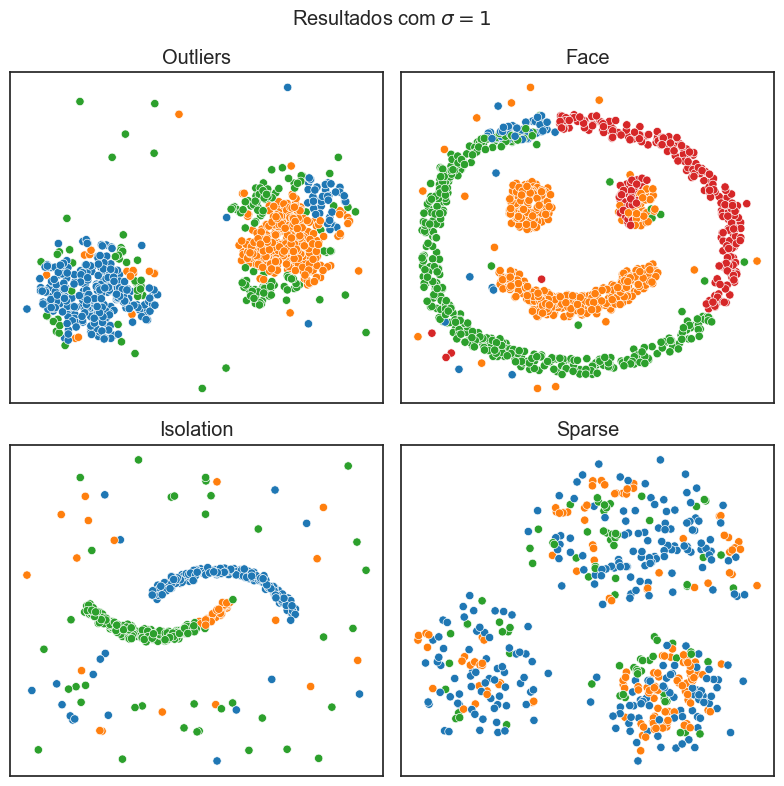

In [14]:
inicio = timer()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

X = pd.read_csv("testes/outliers.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral(X, 3, 1), palette="tab10", legend=False, ax=axes[0][0])
axes[0][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][0].set_title("Outliers", fontsize="large")

X = pd.read_csv("testes/face.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral(X, 4, 1), palette="tab10", legend=False, ax=axes[0][1])
axes[0][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][1].set_title("Face", fontsize="large")

X = pd.read_csv("testes/isolation.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral(X, 3, 1), palette="tab10", legend=False, ax=axes[1][0])
axes[1][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][0].set_title("Isolation", fontsize="large")

X = pd.read_csv("testes/sparse.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral(X, 3, 1), palette="tab10", legend=False, ax=axes[1][1])
axes[1][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][1].set_title("Sparse", fontsize="large")

print(timer() - inicio)
fig.suptitle(r"Resultados com $\sigma = 1$")
fig.tight_layout()

### Escala local

11.857318500002293


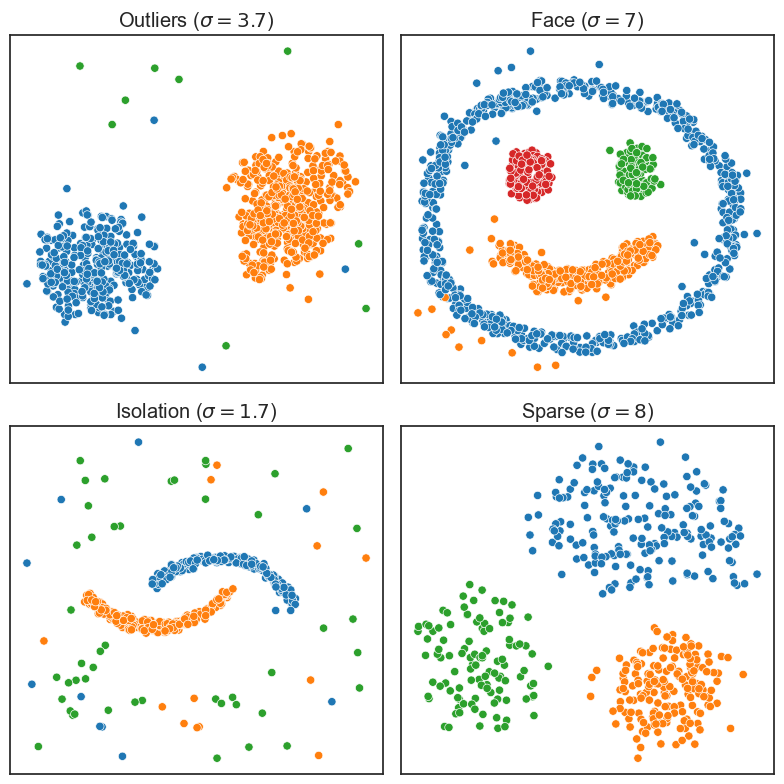

In [15]:
inicio = timer()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

X = pd.read_csv("testes/outliers.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral(X, 3, 3.7), palette="tab10", legend=False, ax=axes[0][0])
axes[0][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][0].set_title(r"Outliers ($\sigma = 3.7$)", fontsize="large")

X = pd.read_csv("testes/face.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral(X, 4, 7), palette="tab10", legend=False, ax=axes[0][1])
axes[0][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][1].set_title(r"Face ($\sigma = 7$)", fontsize="large")

X = pd.read_csv("testes/isolation.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral(X, 3, 1.7), palette="tab10", legend=False, ax=axes[1][0])
axes[1][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][0].set_title(r"Isolation ($\sigma = 1.7$)", fontsize="large")

X = pd.read_csv("testes/sparse.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral(X, 3, 8), palette="tab10", legend=False, ax=axes[1][1])
axes[1][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][1].set_title(r"Sparse ($\sigma = 8$)", fontsize="large")

print(timer() - inicio)
fig.tight_layout()

9.506519300000946


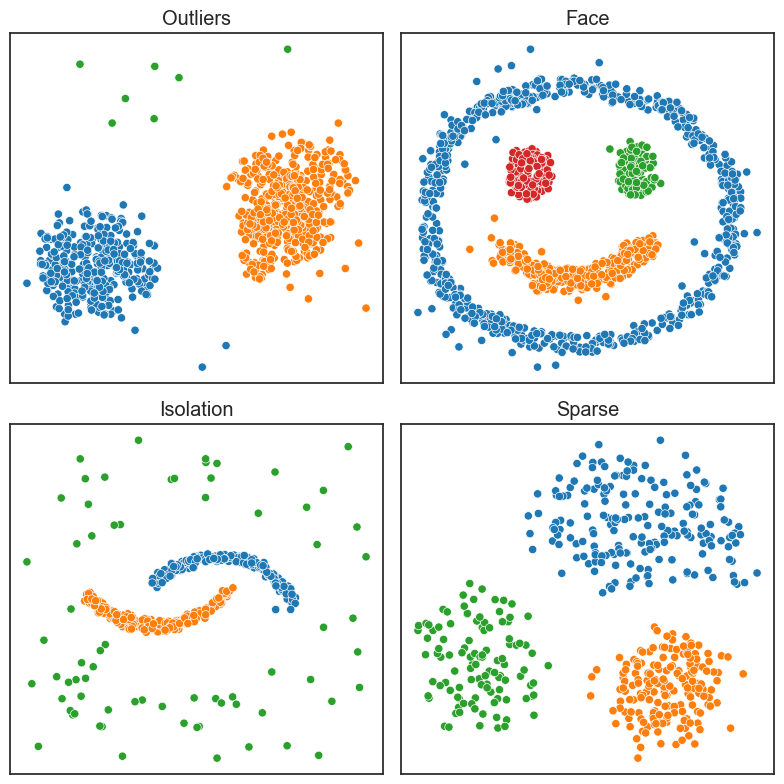

In [16]:
inicio = timer()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

X = pd.read_csv("testes/outliers.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral2(X, 3), palette="tab10", legend=False, ax=axes[0][0])
axes[0][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][0].set_title("Outliers", fontsize="large")

X = pd.read_csv("testes/face.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral2(X, 4), palette="tab10", legend=False, ax=axes[0][1])
axes[0][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][1].set_title("Face", fontsize="large")

X = pd.read_csv("testes/isolation.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral2(X, 3), palette="tab10", legend=False, ax=axes[1][0])
axes[1][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][0].set_title("Isolation", fontsize="large")

X = pd.read_csv("testes/sparse.csv")
sns.scatterplot(X, x="x", y="y", hue=espectral2(X, 3), palette="tab10", legend=False, ax=axes[1][1])
axes[1][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][1].set_title("Sparse", fontsize="large")

print(timer() - inicio)
fig.tight_layout()

### Versão do scikit-learn

In [17]:
from sklearn.cluster import SpectralClustering

C:\Users\Mathe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Mathe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:430: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
C:\Users\Mathe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Mathe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited at iteration 366 with accuracies 
[5.01132370e-14 1.10778608e-05 2.02584343e-05 1.52032967e-05
 1.74425606e-05]
not reaching the requested tolera

356.7524609000029


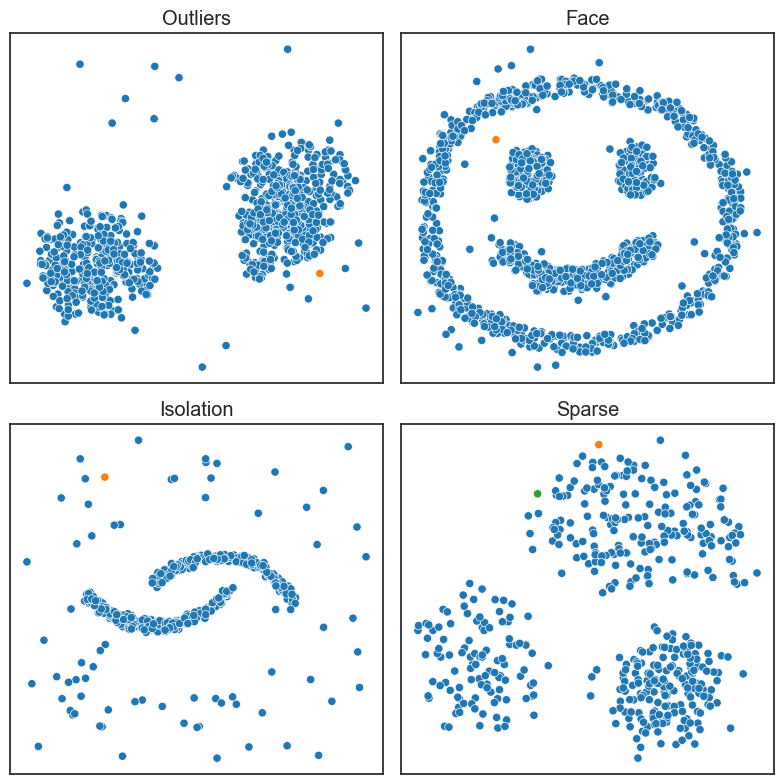

In [18]:
inicio = timer()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

X = pd.read_csv("testes/outliers.csv")
sns.scatterplot(X, x="x", y="y", hue=SpectralClustering(3).fit_predict(X), palette="tab10", legend=False, ax=axes[0][0])
axes[0][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][0].set_title("Outliers", fontsize="large")

X = pd.read_csv("testes/face.csv")
sns.scatterplot(X, x="x", y="y", hue=SpectralClustering(4).fit_predict(X), palette="tab10", legend=False, ax=axes[0][1])
axes[0][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[0][1].set_title("Face", fontsize="large")

X = pd.read_csv("testes/isolation.csv")
sns.scatterplot(X, x="x", y="y", hue=SpectralClustering(3).fit_predict(X), palette="tab10", legend=False, ax=axes[1][0])
axes[1][0].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][0].set_title("Isolation", fontsize="large")

X = pd.read_csv("testes/sparse.csv")
sns.scatterplot(X, x="x", y="y", hue=SpectralClustering(3).fit_predict(X), palette="tab10", legend=False, ax=axes[1][1])
axes[1][1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
axes[1][1].set_title("Sparse", fontsize="large")

print(timer() - inicio)
fig.tight_layout()

### Testes com outros datasets (escala local)

133.66754410000067


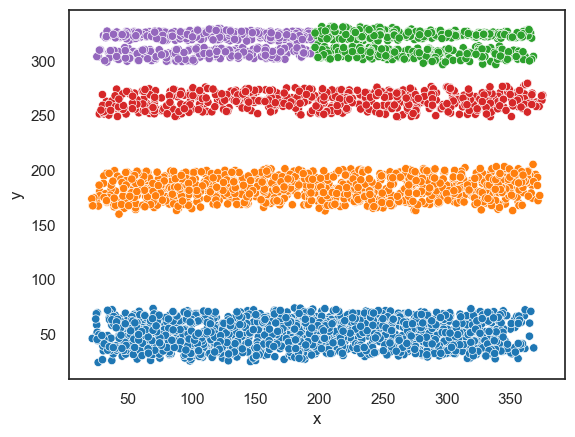

In [19]:
X = pd.read_csv("testes/lines.csv")
inicio = timer()
sns.scatterplot(X, x="x", y="y", hue=espectral2(X, 5), palette="tab10", legend=False)
print(timer() - inicio)

29.512497799998528


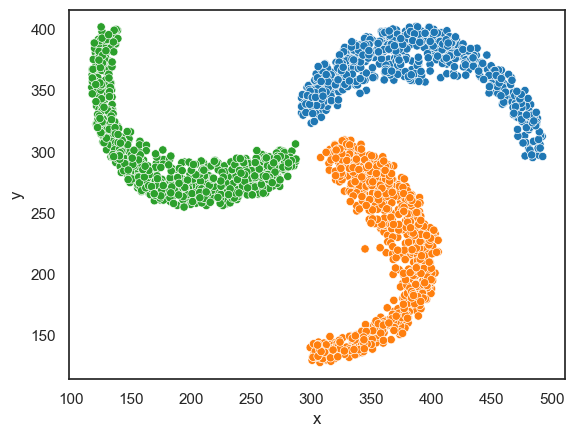

In [20]:
X = pd.read_csv("testes/spirals.csv")
inicio = timer()
sns.scatterplot(X, x="x", y="y", hue=espectral2(X, 3), palette="tab10", legend=False)
print(timer() - inicio)

## Referências
- [On Spectral Clusteting: Analysis and an Algorithm](https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf) - Ng, Jordan, Weiss
- [Self-Tuning Spectral Clustering](https://proceedings.neurips.cc/paper_files/paper/2004/file/40173ea48d9567f1f393b20c855bb40b-Paper.pdf) - Zelnik-Manor, Perona
- [Implementing Self-Tuning Spectral Clustering](https://huiwenn.github.io/spectral-clustering)
- [3 Easy Steps to Understand and Implement Spectral Clustering in Python](https://www.youtube.com/watch?v=YHz0PHcuJnk)
- [A tutorial on spectral clustering](https://sci-hub.se/https://link.springer.com/article/10.1007/s11222-007-9033-z)